In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

from langdetect import detect

%matplotlib inline

In [2]:
df = pd.read_csv('data/online_ship_listing_data.csv')

In [3]:
df.head()

,Unnamed: 0,name,price,location,offerer,id,description,year,manufacturer,model,category,length,fuel_type,hull_material,hull_shape,country
0,0,1976 Ketch Baarda Zeegrundel1976 Ketch Baarda ...,24500.0,"dinteloord, niederlande",Sealion Yachts,8222682,General: The Zeegrundel was originally designe...,1976,Ketch,Baarda Zeegrundel,Lastkahnsegelboote,900.00,diesel,steel,NaN,netherlands
1,1,1979 Dufour 28001979 Dufour 2800,9900.0,"greifswald, deutschland",Privater Verkäufer,8457402,Selling a well-preserved and equipped sailing ...,1979,Dufour,2800,Segelboote mit Kajüte,83.00,diesel,GFK / fiberglas / polyester,NaN,germany
2,2,2010 Van der Graaf Classic Schooner2010 Van de...,12000000.0,"contact de valk antibes, frankreich",De Valk Group B.V,7936534,Model: VAN DER GRAAF CLASSIC SCHOONER Type: sa...,2010,Van der Graaf,Classic Schooner,Slup Boote,65.84,diesel,steel,NaN,france
3,3,2010 Custom Van Der Graaf BV Schooner2010 Cust...,12000000.0,"imperia, italien",Bernard Gallay Yacht Brokerage,6751543,Price On Application\n \nThe current ATLANTIC ...,2010,Custom,Van Der Graaf BV Schooner,Schoner,64.50,diesel,steel,NaN,italy
4,4,2008 Custom Build Gulet2008 Custom Build Gulet,5000000.0,türkei,Gino Group,469955,A beautiful 43m Gulet classic luxury style bui...,2008,Custom Build,Gulet,Segelyachten,42.98,diesel,wood,NaN,turkey


In [4]:
df.shape

(1850, 16)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1850 non-null   int64  
 1   name           1850 non-null   object 
 2   price          1850 non-null   float64
 3   location       1850 non-null   object 
 4   offerer        1850 non-null   object 
 5   id             1850 non-null   int64  
 6   description    1850 non-null   object 
 7   year           1850 non-null   int64  
 8   manufacturer   1850 non-null   object 
 9   model          1843 non-null   object 
 10  category       1850 non-null   object 
 11  length         1850 non-null   float64
 12  fuel_type      1735 non-null   object 
 13  hull_material  1850 non-null   object 
 14  hull_shape     402 non-null    object 
 15  country        1850 non-null   object 
dtypes: float64(2), int64(3), object(11)
memory usage: 231.4+ KB


In [6]:
df.drop(['Unnamed: 0', 'hull_shape'], axis = 1, inplace = True)

In [7]:
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [8]:
df.describe()

,price,id,year,length
count,1.850000e+03,1.850000e+03,1850.000000,1850.000000
mean,2.476051e+05,8.139325e+06,1995.788649,13.340205
std,6.058929e+05,9.206349e+05,21.649481,21.341712
min,1.500000e+01,4.692560e+05,1850.000000,2.500000
25%,3.950000e+04,8.196685e+06,1983.000000,9.740000
50%,9.500000e+04,8.404736e+06,1999.500000,11.820000
75%,2.490000e+05,8.455602e+06,2011.000000,14.625000
max,1.200000e+07,8.522261e+06,2024.000000,900.000000


# Outliers

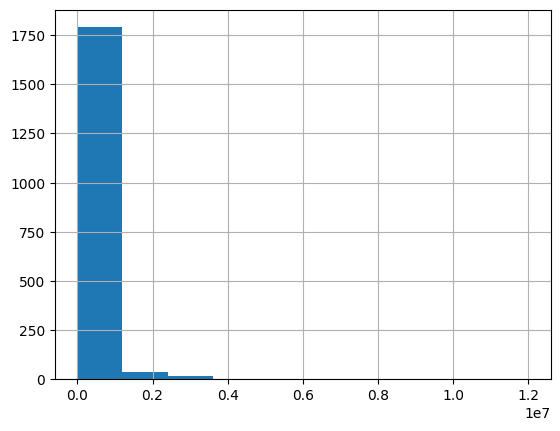

In [9]:
df.price.hist()
plt.show();

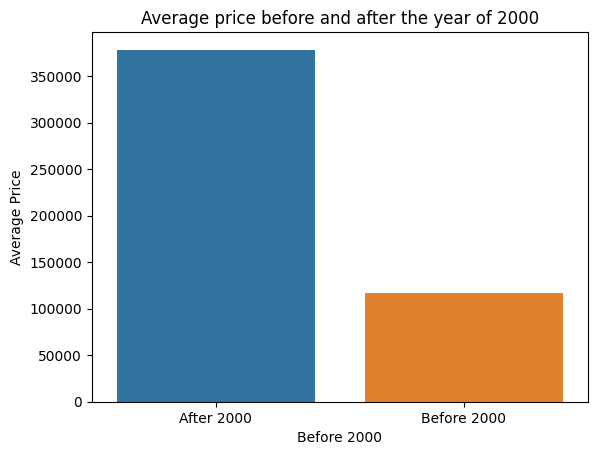

In [10]:
df['before_2000'] = df['year'] < 2000
avg_prices = df.groupby('before_2000')['price'].mean().reset_index()

sns.barplot(x='before_2000', y='price', data=avg_prices)
plt.xlabel('Before 2000')
plt.ylabel('Average Price')
plt.title('Average price before and after the year of 2000')
plt.xticks([0, 1], ['After 2000', 'Before 2000'])
plt.show();

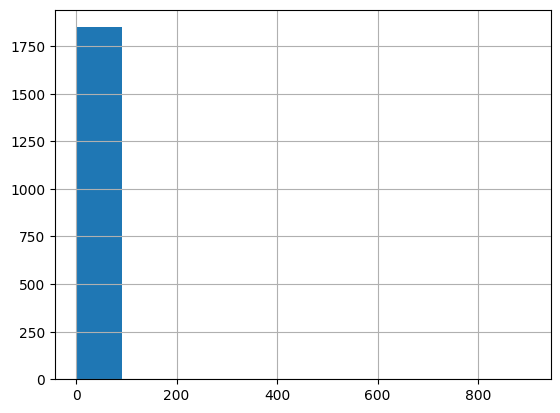

In [11]:
df.length.hist()
plt.show();

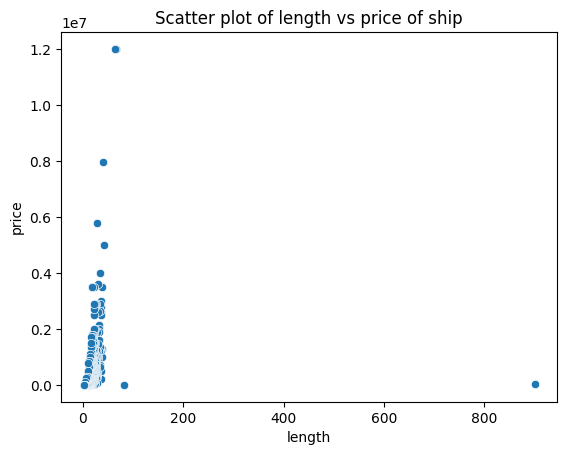

In [12]:
sns.scatterplot(x=df['length'], y=df['price'], data = df)
plt.title('Scatter plot of length vs price of ship')
plt.show();

In [13]:
df[df['price'] == df.price.max()]

,name,price,location,offerer,id,description,year,manufacturer,model,category,length,fuel_type,hull_material,country,before_2000
2,2010 van der graaf classic schooner2010 van de...,12000000.0,"contact de valk antibes, frankreich",de valk group b.v,7936534,model: van der graaf classic schooner type: sa...,2010,van der graaf,classic schooner,slup boote,65.84,diesel,steel,france,False
3,2010 custom van der graaf bv schooner2010 cust...,12000000.0,"imperia, italien",bernard gallay yacht brokerage,6751543,price on application\n \nthe current atlantic ...,2010,custom,van der graaf bv schooner,schoner,64.50,diesel,steel,italy,False


In [14]:
df[df['length'] == df.length.max()]

,name,price,location,offerer,id,description,year,manufacturer,model,category,length,fuel_type,hull_material,country,before_2000
0,1976 ketch baarda zeegrundel1976 ketch baarda ...,24500.0,"dinteloord, niederlande",sealion yachts,8222682,general: the zeegrundel was originally designe...,1976,ketch,baarda zeegrundel,lastkahnsegelboote,900.0,diesel,steel,netherlands,True


There are outliers in price and length

In [15]:
def clip_outliers(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    upper_threshold = q3 + (1.5 * (q3 - q1))
    df[col] = df[col].clip(upper=upper_threshold)

In [16]:
for col in ['price', 'length']:
    clip_outliers(df, col)

In [17]:
df.describe()

,price,id,year,length
count,1850.000000,1.850000e+03,1850.000000,1850.000000
mean,169987.085405,8.139325e+06,1995.788649,12.485593
std,175469.631782,9.206349e+05,21.649481,3.964729
min,15.000000,4.692560e+05,1850.000000,2.500000
25%,39500.000000,8.196685e+06,1983.000000,9.740000
50%,95000.000000,8.404736e+06,1999.500000,11.820000
75%,249000.000000,8.455602e+06,2011.000000,14.625000
max,563250.000000,8.522261e+06,2024.000000,21.952500


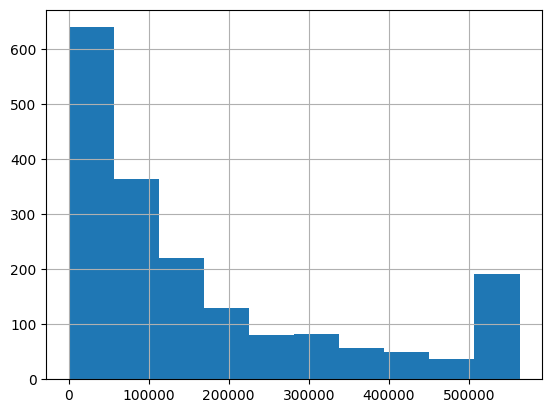

In [18]:
df.price.hist()
plt.show();

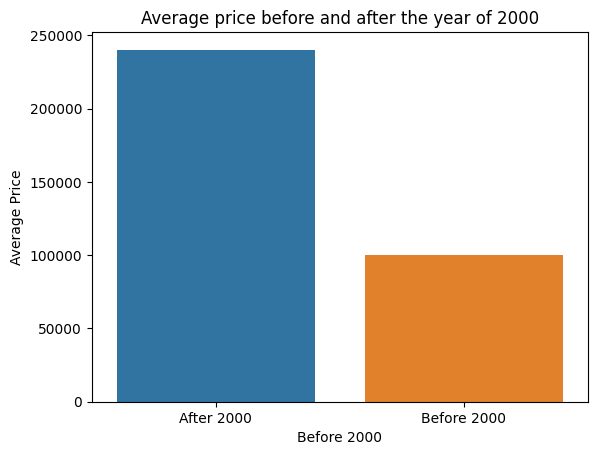

In [19]:
df['before_2000'] = df['year'] < 2000
avg_prices = df.groupby('before_2000')['price'].mean().reset_index()

sns.barplot(x='before_2000', y='price', data=avg_prices)
plt.xlabel('Before 2000')
plt.ylabel('Average Price')
plt.title('Average price before and after the year of 2000')
plt.xticks([0, 1], ['After 2000', 'Before 2000'])
plt.show();

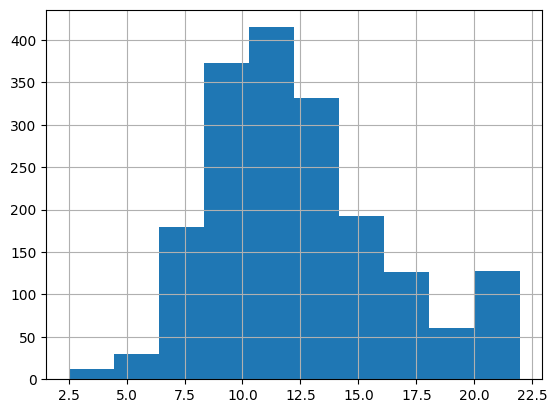

In [20]:
df.length.hist()
plt.show()

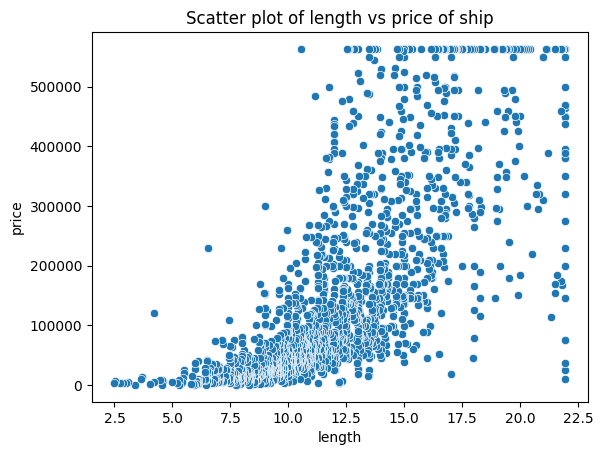

In [21]:
sns.scatterplot(x=df['length'], y=df['price'], data = df)
plt.title('Scatter plot of length vs price of ship')
plt.show();

# EDA

1. Imputing missing values for fuel_type and model
2. Avg Price by Country
3. Avg Price by Manufacturer
4. Avg Price by Fuel Type
5. Avg Price by Category

## Imputing missing values for fuel_type and model

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           1850 non-null   object 
 1   price          1850 non-null   float64
 2   location       1850 non-null   object 
 3   offerer        1850 non-null   object 
 4   id             1850 non-null   int64  
 5   description    1850 non-null   object 
 6   year           1850 non-null   int64  
 7   manufacturer   1850 non-null   object 
 8   model          1843 non-null   object 
 9   category       1850 non-null   object 
 10  length         1850 non-null   float64
 11  fuel_type      1735 non-null   object 
 12  hull_material  1850 non-null   object 
 13  country        1850 non-null   object 
 14  before_2000    1850 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(10)
memory usage: 204.3+ KB


In [23]:
def impute_knn(df, subset, text_columns):
    #divide data into 2
    data_complete = df.dropna(subset=subset).reset_index(drop = True)
    data_missing = df[df[subset].isnull()].reset_index(drop = True)
    #data_missing[subset] = data_missing.astype('str')
    
    #create tfidf vectorizer, join all the text in the text_columns into one string
    vectorizer = TfidfVectorizer()
    text_data = data_complete[text_columns].astype('str').apply(lambda x: ' '.join(x), axis=1)
    #create tfidf_matrix
    tfidf_matrix = vectorizer.fit_transform(text_data)
    
    #fit the model
    nn_model = NearestNeighbors(n_neighbors=3)  # Choose an appropriate value
    nn_model.fit(tfidf_matrix)
    for idx, row in data_missing.iterrows():
        #convert text_columns 
        row[text_columns] = row[text_columns].astype('str')
        #transform the text_columns in the data_missing into vector representation
        text_representation = vectorizer.transform([' '.join(row[text_columns])])
        #distance calculation
        _, indices = nn_model.kneighbors(text_representation)
        #get indices from the current row from data_complete
        neighbor_models = data_complete.loc[indices[0], subset]
        #calculate most frequent value
        imputed_data = neighbor_models.mode()[0]
        #impute the data
        data_missing.loc[idx, subset] = imputed_data
    
    data_complete = pd.DataFrame(np.concatenate((data_complete, data_missing), axis=0), columns = df.columns)
    return data_complete

In [24]:
df_model = impute_knn(df, 'model', ['country', 'manufacturer', 'offerer', 'category', 'hull_material'])

In [25]:
df_fuel = impute_knn(df_model, 'fuel_type', ['country', 'manufacturer', 'offerer', 'category', 'hull_material', 'model'])

In [26]:
df_raw = df.copy()
df = df_fuel

## Exploring price and its correlations with other variables

In [27]:
df.head()

,name,price,location,offerer,id,description,year,manufacturer,model,category,length,fuel_type,hull_material,country,before_2000
0,1976 ketch baarda zeegrundel1976 ketch baarda ...,24500.0,"dinteloord, niederlande",sealion yachts,8222682,general: the zeegrundel was originally designe...,1976,ketch,baarda zeegrundel,lastkahnsegelboote,21.9525,diesel,steel,netherlands,True
1,1979 dufour 28001979 dufour 2800,9900.0,"greifswald, deutschland",privater verkäufer,8457402,selling a well-preserved and equipped sailing ...,1979,dufour,2800,segelboote mit kajüte,21.9525,diesel,gfk / fiberglas / polyester,germany,True
2,2010 van der graaf classic schooner2010 van de...,563250.0,"contact de valk antibes, frankreich",de valk group b.v,7936534,model: van der graaf classic schooner type: sa...,2010,van der graaf,classic schooner,slup boote,21.9525,diesel,steel,france,False
3,2010 custom van der graaf bv schooner2010 cust...,563250.0,"imperia, italien",bernard gallay yacht brokerage,6751543,price on application\n \nthe current atlantic ...,2010,custom,van der graaf bv schooner,schoner,21.9525,diesel,steel,italy,False
4,2008 custom build gulet2008 custom build gulet,563250.0,türkei,gino group,469955,a beautiful 43m gulet classic luxury style bui...,2008,custom build,gulet,segelyachten,21.9525,diesel,wood,turkey,False


In [28]:
df.price.describe()

count       1850.0
unique       680.0
top       563250.0
freq         167.0
Name: price, dtype: float64

In [29]:
df.country.value_counts()

country
afghanistan         457
germany             310
netherlands         251
italy               225
spain               180
turkey               89
france               66
croatia              65
portugal             62
greece               45
poland               31
grenada              16
austria               8
belgium               7
denmark               6
tunisia               5
switzerland           5
sweden                2
cyprus                2
martinique            2
hungary               1
slovakia              1
dominica              1
ireland               1
panama                1
slovenia              1
bulgaria              1
israel                1
malta                 1
new zealand           1
bahamas               1
norway                1
thailand              1
french polynesia      1
barbados              1
egypt                 1
Name: count, dtype: int64

In [30]:
top_countries = df['country'].value_counts().head(10).index

In [31]:
df['new_country'] = df['country'].apply(lambda x:x if x in top_countries else 'other')

In [32]:
df.new_country.value_counts()

new_country
afghanistan    457
germany        310
netherlands    251
italy          225
spain          180
other          100
turkey          89
france          66
croatia         65
portugal        62
greece          45
Name: count, dtype: int64

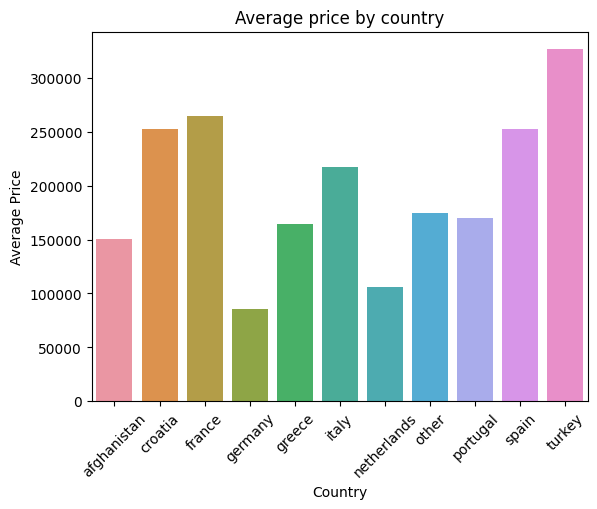

In [33]:
price_by_country = df.groupby('new_country')['price'].mean().reset_index()

sns.barplot(x='new_country', y='price', data=price_by_country)
plt.xlabel('Country')
plt.ylabel('Average Price')
plt.title('Average price by country')
plt.xticks(rotation=45)
plt.show();

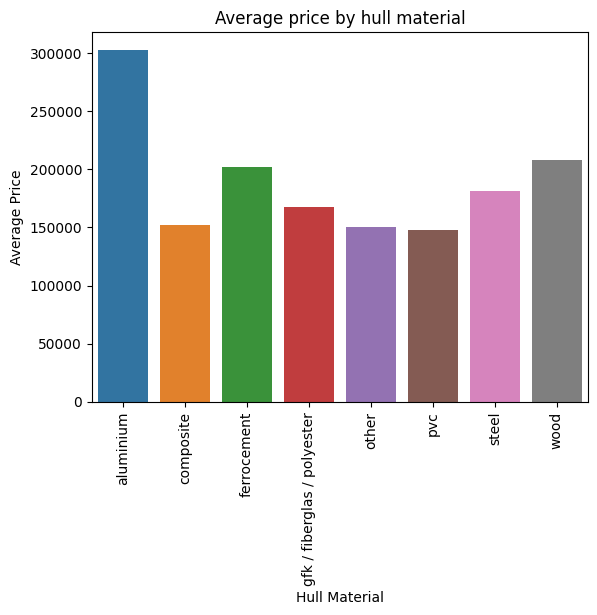

In [34]:
price_by_hull_material = df.groupby('hull_material')['price'].mean().reset_index()

sns.barplot(x='hull_material', y='price', data=price_by_hull_material)
plt.xlabel('Hull Material')
plt.ylabel('Average Price')
plt.title('Average price by hull material')
plt.xticks(rotation=90)
plt.show();

In [35]:
df[df['fuel_type'].isnull()]

,name,price,location,offerer,id,description,year,manufacturer,model,category,length,fuel_type,hull_material,country,before_2000,new_country


In [36]:
#fuel type
df.dropna(subset='fuel_type', inplace = True) #drop 

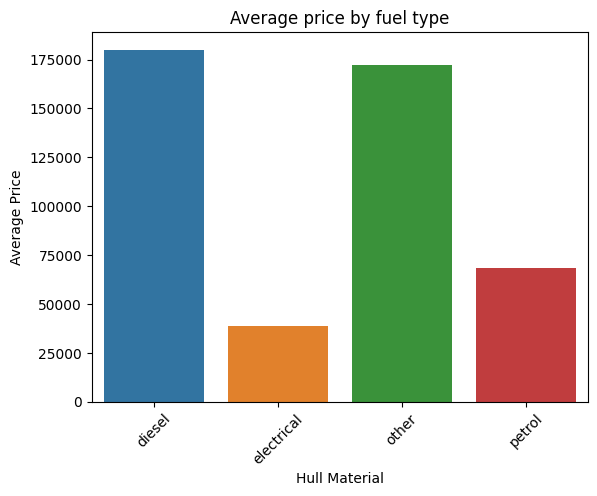

In [37]:
price_by_fuel_type = df.groupby('fuel_type')['price'].mean().reset_index()

sns.barplot(x='fuel_type', y='price', data=price_by_fuel_type)
plt.xlabel('Hull Material')
plt.ylabel('Average Price')
plt.title('Average price by fuel type')
plt.xticks(rotation=45)
plt.show();

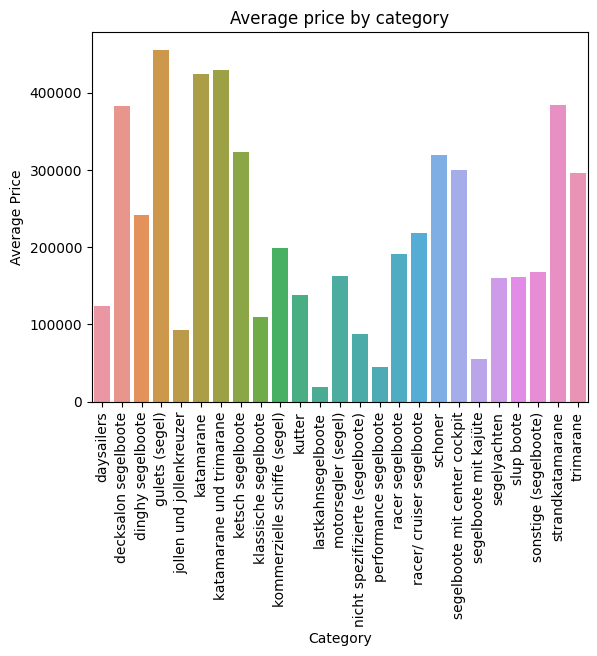

In [38]:
price_by_category = df.groupby('category')['price'].mean().reset_index()

sns.barplot(x='category', y='price', data=price_by_category)
plt.xlabel('Category')
plt.ylabel('Average Price')
plt.title('Average price by category')
plt.xticks(rotation=90)
plt.show();

# Text Data

In [39]:
#word count
df['word_count'] = df['description'].apply(lambda x: len(re.findall(r'\w+', x)))

In [40]:
df['word_count'].mean()

215.7183783783784

In [41]:
df['word_count'].describe()

count    1850.000000
mean      215.718378
std       329.561411
min         2.000000
25%        56.000000
50%       138.000000
75%       257.750000
max      5622.000000
Name: word_count, dtype: float64

In [42]:
df = df[df['word_count'] > 20]

In [43]:
df.shape

(1592, 17)

In [44]:
df[df['word_count'] == df['word_count'].min()].description

47      now available for inspections in southern turk...
95      sertral 72, plan mauric, professional boat com...
603     there is some deferred maintenance\n\n\nriggin...
724     sailboat ready to buoy\n3 cabins: 1 double in ...
807     2001 beneteau oceanis 411,\nxboat ref 2061.boa...
876     - teak cockpit - minimalist arm with maneuvers...
1384    mainsail as new doyle/raudaschl (high-tech 17m...
1482    1928 cn corcelle st tropez pointu,\nxboat ref ...
1630    price is a basis for negotiation underwater sh...
Name: description, dtype: object

In [45]:
df['description_language'] = df['description'].apply(lambda x:detect(x))

C:\Users\agust\AppData\Local\Temp\ipykernel_33524\3131039673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description_language'] = df['description'].apply(lambda x:detect(x))


In [46]:
df['description_language'].value_counts()

description_language
en    1541
fr      22
it      14
nl       8
de       3
es       2
pl       1
hu       1
Name: count, dtype: int64

In [47]:
df = df[df['description_language'] == 'en']

In [48]:
df['description'] = df['description'].str.replace('show more', '')
df['description'] = df['description'].str.replace('mehr anzeigen', '')

In [49]:
df.head()

,name,price,location,offerer,id,description,year,manufacturer,model,category,length,fuel_type,hull_material,country,before_2000,new_country,word_count,description_language
0,1976 ketch baarda zeegrundel1976 ketch baarda ...,24500.0,"dinteloord, niederlande",sealion yachts,8222682,general: the zeegrundel was originally designe...,1976,ketch,baarda zeegrundel,lastkahnsegelboote,21.9525,diesel,steel,netherlands,True,netherlands,390,en
1,1979 dufour 28001979 dufour 2800,9900.0,"greifswald, deutschland",privater verkäufer,8457402,selling a well-preserved and equipped sailing ...,1979,dufour,2800,segelboote mit kajüte,21.9525,diesel,gfk / fiberglas / polyester,germany,True,germany,326,en
2,2010 van der graaf classic schooner2010 van de...,563250.0,"contact de valk antibes, frankreich",de valk group b.v,7936534,model: van der graaf classic schooner type: sa...,2010,van der graaf,classic schooner,slup boote,21.9525,diesel,steel,france,False,france,220,en
3,2010 custom van der graaf bv schooner2010 cust...,563250.0,"imperia, italien",bernard gallay yacht brokerage,6751543,price on application\n \nthe current atlantic ...,2010,custom,van der graaf bv schooner,schoner,21.9525,diesel,steel,italy,False,italy,298,en
4,2008 custom build gulet2008 custom build gulet,563250.0,türkei,gino group,469955,a beautiful 43m gulet classic luxury style bui...,2008,custom build,gulet,segelyachten,21.9525,diesel,wood,turkey,False,turkey,50,en


In [50]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\agust\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agust\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\agust\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [51]:
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
# Preprocessing the text data

REPLACE_BY_SPACE_RE = re.compile("[/(){}\[\]\|@,;!]")
BAD_SYMBOLS_RE = re.compile("[^0-9a-z #+_]")
STOPWORDS_nlp = set(stopwords.words('english'))

#Custom Stoplist
stoplist = ["i","project","living","home",'apartment',"pune","me","my","myself","we","our","ours","ourselves","you","you're","you've","you'll","you'd","your",
            "yours","yourself","yourselves","he","him","his","himself","she","she's","her","hers","herself","it",
            "it's","its","itself","they","them","their","theirs","themselves","what","which","who","whom","this","that","that'll",
            "these","those","am","is","are","was","were","be","been","being","have","has","had","having","do","does","did",
            "doing","a","an","the","and","but","if","or","because","as","until","while","of","at","by","for","with","about",
            "against","between","into","through","during","before","after","above","below","to","from","up","down","in","out",
            "on","off","over","under","again","further","then","once","here","there","when","where","why","all","any",
            "both","each","few","more","most","other","some","such","no","nor","not","only","own","same","so","than","too",
            "very","s","t","can","will","just","don","don't","should","should've","now","d","ll","m","o","re","ve","y","ain",
            "aren","couldn","didn","doesn","hadn","hasn",
            "haven","isn","ma","mightn","mustn","needn","shan","shan't",
            "shouldn","wasn","weren","won","rt","rt","qt","for",
            "the","with","in","of","and","its","it","this","i","have","has","would","could","you","a","an",
            "be","am","can","edushopper","will","to","on","is","by","ive","im","your","we","are","at","as","any","ebay","thank","hello","know",
            "need","want","look","hi","sorry","http", "https","body","dear","hello","hi","thanks","sir","tomorrow","sent","send","see","there","welcome","what","well","us"]

STOPWORDS_nlp.update(stoplist)

# Function to preprocess the text
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.replace("\d+"," ") # removing digits
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #removing mentions and urls
    text = text.lower() # lowercase text
    text =  re.sub('[0-9]+', '', text)
    text = REPLACE_BY_SPACE_RE.sub(" ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub(" ", text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS_nlp]) # delete stopwors from text
    text = text.strip()
    return text


In [53]:
df_text = df['description'].apply(text_prepare)

In [54]:
df_text.head()

0    general zeegrundel originally designed around ...
1    selling preserved equipped sailing yacht dufou...
2    model van der graaf classic schooner type sail...
3    price application current atlantic replica leg...
4    beautiful gulet classic luxury style built hig...
Name: description, dtype: object

In [55]:
text = " ".join(sent for sent in df_text)
print("There are {} words in the text.".format(len(text)))

There are 1586953 words in the text.


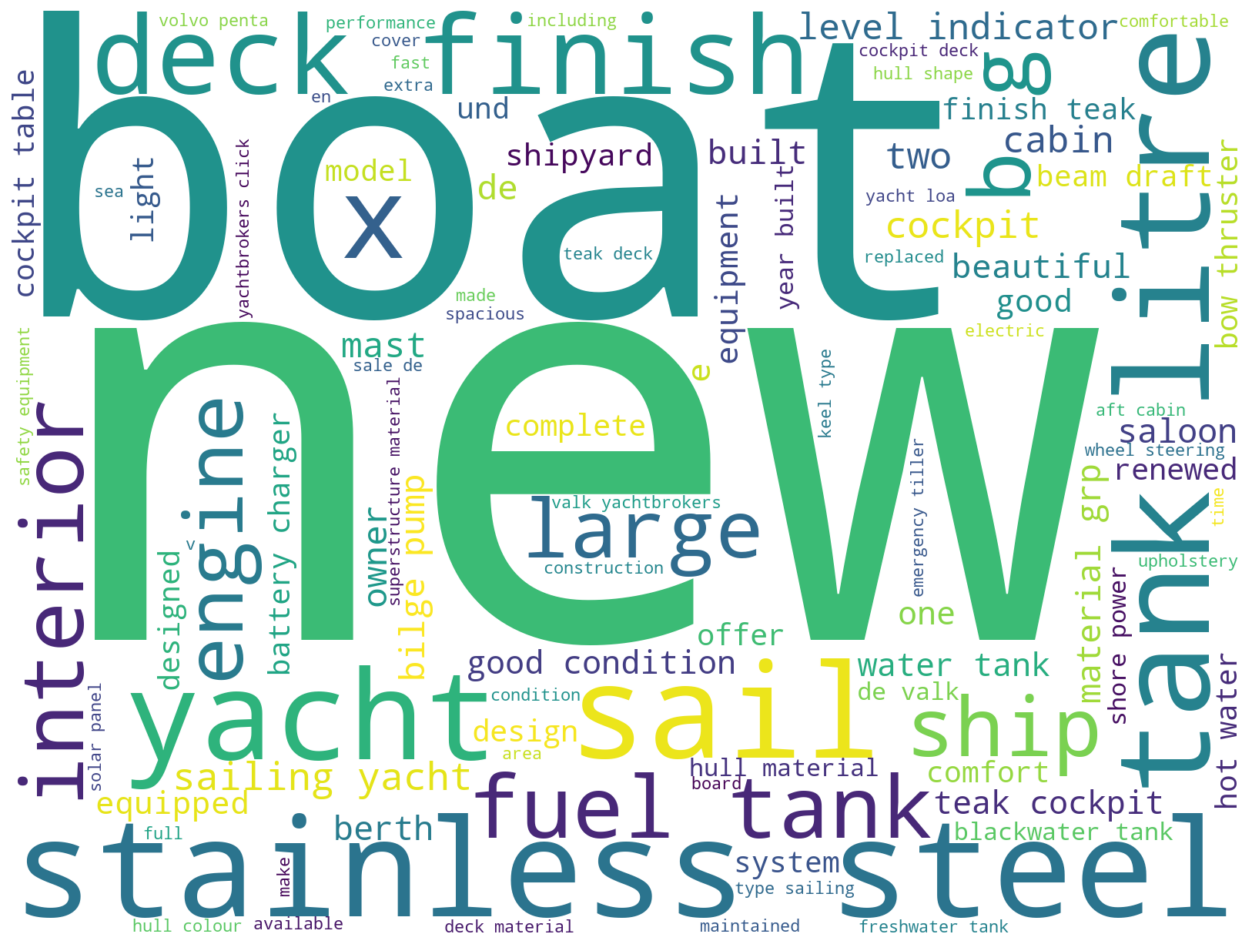

In [56]:
wordcloud = WordCloud(background_color = "white", height=1200, width= 1600, collocations=True , max_words= 100).generate(text)
plt.figure(figsize= (16,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

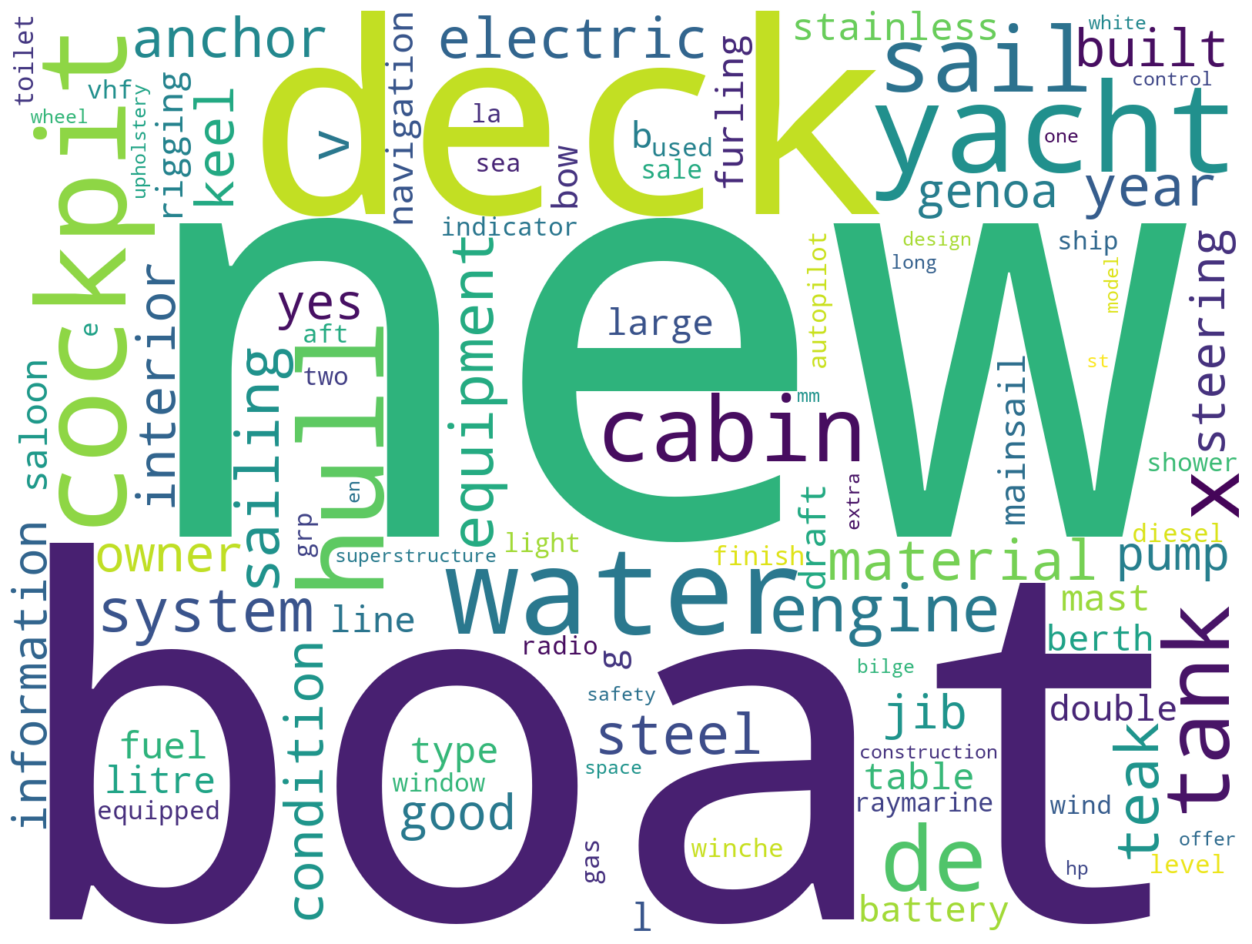

In [57]:
wordcloud = WordCloud(background_color = "white", height=1200, width= 1600, collocations=False , max_words= 100).generate(text)
plt.figure(figsize= (16,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [58]:
df['description_cleaned'] = df['description'].astype('str').apply(text_prepare)

In [59]:
from collections import Counter

def pos_counter(x,pos):
    """
    Returns the count for the given parts of speech tag
    
    NN - Noun
    VB - Verb
    JJ - Adjective
    RB - Adverb
    """
    tokens = nltk.word_tokenize(x.lower())
    tokens = [word for word in tokens if word not in STOPWORDS_nlp]
    text = nltk.Text(tokens)
    tags = nltk.pos_tag(text)
    counts = Counter(tag for word,tag in tags)
    return counts[pos]

df['noun_counts'] = df['description_cleaned'].apply(lambda x: pos_counter(x,'NN'))
df['verb_counts'] = df['description_cleaned'].apply(lambda x: (pos_counter(x,'VB')+pos_counter(x,'RB')))
df['adjective_counts'] = df['description_cleaned'].apply(lambda x: pos_counter(x,'JJ'))

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1541 entries, 0 to 1848
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   name                  1541 non-null   object
 1   price                 1541 non-null   object
 2   location              1541 non-null   object
 3   offerer               1541 non-null   object
 4   id                    1541 non-null   object
 5   description           1541 non-null   object
 6   year                  1541 non-null   object
 7   manufacturer          1541 non-null   object
 8   model                 1541 non-null   object
 9   category              1541 non-null   object
 10  length                1541 non-null   object
 11  fuel_type             1541 non-null   object
 12  hull_material         1541 non-null   object
 13  country               1541 non-null   object
 14  before_2000           1541 non-null   object
 15  new_country           1541 non-null   objec

In [61]:
df.head()

,name,price,location,offerer,id,description,year,manufacturer,model,category,...,hull_material,country,before_2000,new_country,word_count,description_language,description_cleaned,noun_counts,verb_counts,adjective_counts
0,1976 ketch baarda zeegrundel1976 ketch baarda ...,24500.0,"dinteloord, niederlande",sealion yachts,8222682,general: the zeegrundel was originally designe...,1976,ketch,baarda zeegrundel,lastkahnsegelboote,...,steel,netherlands,True,netherlands,390,en,general zeegrundel originally designed around ...,97,10,37
1,1979 dufour 28001979 dufour 2800,9900.0,"greifswald, deutschland",privater verkäufer,8457402,selling a well-preserved and equipped sailing ...,1979,dufour,2800,segelboote mit kajüte,...,gfk / fiberglas / polyester,germany,True,germany,326,en,selling preserved equipped sailing yacht dufou...,84,10,36
2,2010 van der graaf classic schooner2010 van de...,563250.0,"contact de valk antibes, frankreich",de valk group b.v,7936534,model: van der graaf classic schooner type: sa...,2010,van der graaf,classic schooner,slup boote,...,steel,france,False,france,220,en,model van der graaf classic schooner type sail...,75,2,31
3,2010 custom van der graaf bv schooner2010 cust...,563250.0,"imperia, italien",bernard gallay yacht brokerage,6751543,price on application\n \nthe current atlantic ...,2010,custom,van der graaf bv schooner,schoner,...,steel,italy,False,italy,298,en,price application current atlantic replica leg...,57,9,34
4,2008 custom build gulet2008 custom build gulet,563250.0,türkei,gino group,469955,a beautiful 43m gulet classic luxury style bui...,2008,custom build,gulet,segelyachten,...,wood,turkey,False,turkey,50,en,beautiful gulet classic luxury style built hig...,8,3,6


In [62]:
description_vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features = 10)

In [63]:
tfidf_object = description_vectorizer.fit(df['description_cleaned'])

In [64]:
import pickle
fileName = 'model/tfidf_vectorizer.pkl'
with open(fileName,'wb') as f:
    pickle.dump(tfidf_object,f)

In [65]:
tfidf_matrix = tfidf_object.transform(df['description_cleaned'])

In [66]:
tfidf_matrix.shape

(1541, 10)

In [67]:
feature_names = description_vectorizer.get_feature_names_out()

In [68]:
tfidf_object.get_feature_names_out()

array(['bilge pump', 'deck finish', 'fuel tank', 'good condition',
       'level indicator', 'material grp', 'sailing yacht',
       'stainless steel', 'tank litre', 'teak cockpit'], dtype=object)

In [69]:
tfidf_array = tfidf_matrix.toarray()

In [70]:
tfidf_df = pd.DataFrame(tfidf_array, columns=feature_names)

In [71]:
tfidf_df.shape

(1541, 10)

In [72]:
df.shape

(1541, 22)

In [73]:
df_use = pd.concat([df.reset_index(drop=True),tfidf_df.reset_index(drop=True)],axis=1)

In [74]:
df_use.head()

,name,price,location,offerer,id,description,year,manufacturer,model,category,...,bilge pump,deck finish,fuel tank,good condition,level indicator,material grp,sailing yacht,stainless steel,tank litre,teak cockpit
0,1976 ketch baarda zeegrundel1976 ketch baarda ...,24500.0,"dinteloord, niederlande",sealion yachts,8222682,general: the zeegrundel was originally designe...,1976,ketch,baarda zeegrundel,lastkahnsegelboote,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
1,1979 dufour 28001979 dufour 2800,9900.0,"greifswald, deutschland",privater verkäufer,8457402,selling a well-preserved and equipped sailing ...,1979,dufour,2800,segelboote mit kajüte,...,0.0,0.000000,0.000000,0.0,0.0,0.0,1.00000,0.0,0.000000,0.0
2,2010 van der graaf classic schooner2010 van de...,563250.0,"contact de valk antibes, frankreich",de valk group b.v,7936534,model: van der graaf classic schooner type: sa...,2010,van der graaf,classic schooner,slup boote,...,0.0,0.418407,0.186311,0.0,0.0,0.0,0.35062,0.0,0.816878,0.0
3,2010 custom van der graaf bv schooner2010 cust...,563250.0,"imperia, italien",bernard gallay yacht brokerage,6751543,price on application\n \nthe current atlantic ...,2010,custom,van der graaf bv schooner,schoner,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
4,2008 custom build gulet2008 custom build gulet,563250.0,türkei,gino group,469955,a beautiful 43m gulet classic luxury style bui...,2008,custom build,gulet,segelyachten,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0


## Cleaning other text variables from special characters 

In [75]:
def clean_columns(column_list):
    all_cols = column_list
    
    modified_list = []

    for item in all_cols:
        item = str(item).lower()
        modified_item = re.sub(r'[^a-zA-Z0-9]', '_', item)
        modified_list.append(modified_item)
    
    final_list = []
    
    for i in modified_list:
        cleaned_column_name = re.sub(r'_+', '_', i)
        final_list.append(cleaned_column_name)
    
    final_list = [col.strip('_') for col in final_list]
    return final_list

In [76]:
text_cols = ['model', 'category', 'hull_material', 'country', 'fuel_type']
for col in text_cols:
    df_use[col] = clean_columns(df_use[col].tolist())

## Feature engineering - price-based feature

In [77]:
price_by_hull_material = df_use.groupby('hull_material')['price'].mean().to_dict()

import pickle
fileName = 'model/price_by_hull_material.pkl'
with open(fileName,'wb') as f:
    pickle.dump(price_by_hull_material,f)

average_value_hull_material = sum(price_by_hull_material.values()) / len(price_by_hull_material)
df_use['avg_price_by_hull_material'] = df_use['hull_material'].apply(lambda x: price_by_hull_material.get(x, average_value_hull_material))

In [78]:
price_by_hull_material

{'aluminium': 312075.91071428574,
 'composite': 158904.856,
 'gfk_fiberglas_polyester': 158617.6945736434,
 'other': 146301.27878787878,
 'pvc': 218083.33333333334,
 'steel': 173764.8396226415,
 'wood': 181466.51351351352}

In [79]:
price_by_fuel_type = df_use.groupby('fuel_type')['price'].mean().to_dict()

import pickle
fileName = 'model/price_by_fuel_type.pkl'
with open(fileName,'wb') as f:
    pickle.dump(price_by_fuel_type,f)

average_value_fuel_type = sum(price_by_fuel_type.values()) / len(price_by_fuel_type)
df_use['avg_price_by_fuel_type'] = df_use['fuel_type'].apply(lambda x: price_by_fuel_type.get(x, average_value_fuel_type))

In [80]:
price_by_fuel_type

{'diesel': 172026.98619186046,
 'electrical': 40325.53846153846,
 'other': 175899.2162162162,
 'petrol': 72954.04494382022}

In [81]:
price_by_category = df_use.groupby('category')['price'].mean().to_dict()

import pickle
fileName = 'model/price_by_category.pkl'
with open(fileName,'wb') as f:
    pickle.dump(price_by_category,f)

average_value_category = sum(price_by_category.values()) / len(price_by_category)
df_use['avg_price_by_category'] = df_use['category'].apply(lambda x: price_by_category.get(x, average_value_category))

In [82]:
price_by_category

{'daysailers': 122931.77165354331,
 'decksalon_segelboote': 346625.0,
 'dinghy_segelboote': 239785.7142857143,
 'gulets_segel': 411666.6666666667,
 'jollen_und_jollenkreuzer': 93250.0,
 'katamarane': 431646.1395348837,
 'katamarane_und_trimarane': 412096.8125,
 'ketsch_segelboote': 340750.0,
 'klassische_segelboote': 112098.68831168831,
 'kommerzielle_schiffe_segel': 199500.0,
 'kutter': 148226.8,
 'lastkahnsegelboote': 19250.0,
 'motorsegler_segel': 140765.48648648648,
 'nicht_spezifizierte_segelboote': 69062.69230769231,
 'racer_cruiser_segelboote': 224576.79545454544,
 'racer_segelboote': 198303.16666666666,
 'schoner': 476125.0,
 'segelboote_mit_center_cockpit': 285714.71428571426,
 'segelboote_mit_kaj_te': 66037.5,
 'segelyachten': 154957.04319654428,
 'slup_boote': 162532.0994764398,
 'sonstige_segelboote': 108224.21052631579,
 'strandkatamarane': 20000.0,
 'trimarane': 358926.0}